<a href="https://colab.research.google.com/github/chandrusuresh/Hands-On-ML/blob/master/Ch2/District_Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
# from mpl_toolkits.basemap import Basemap

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import urllib
import os
import shutil
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix

from google.colab import drive
drive.mount('/content/drive')
dataset_dir = '/content/drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

### Data Download

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master"
HOUSING_PATH = "datasets/housing"
HOUSING_FILE = "housing.tgz"
FULL_URL = DOWNLOAD_ROOT + "/" + HOUSING_PATH + "/" + HOUSING_FILE
download_dir = os.path.join(dataset_dir,HOUSING_PATH)

def download_data(url):
  if not os.path.exists(download_dir):
    os.makedirs(download_dir)
  tgz_path = os.path.join(download_dir,HOUSING_FILE)
  urllib.request.urlretrieve(url,tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=download_dir)
  housing_tgz.close()

def load_data(url = FULL_URL):
  if not os.path.exists(os.path.join(download_dir,HOUSING_FILE)):
    download_data(url)
  csv_path = os.path.join(download_dir,"housing.csv")
  return pd.read_csv(csv_path)

### Data Header

In [3]:
## Download & Load data
housing = load_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Data Info

In [4]:
housing.info()
print()
print()
print('Counts of Ocean Proximity')
housing["ocean_proximity"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Counts of Ocean Proximity


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Data Description

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Histogram

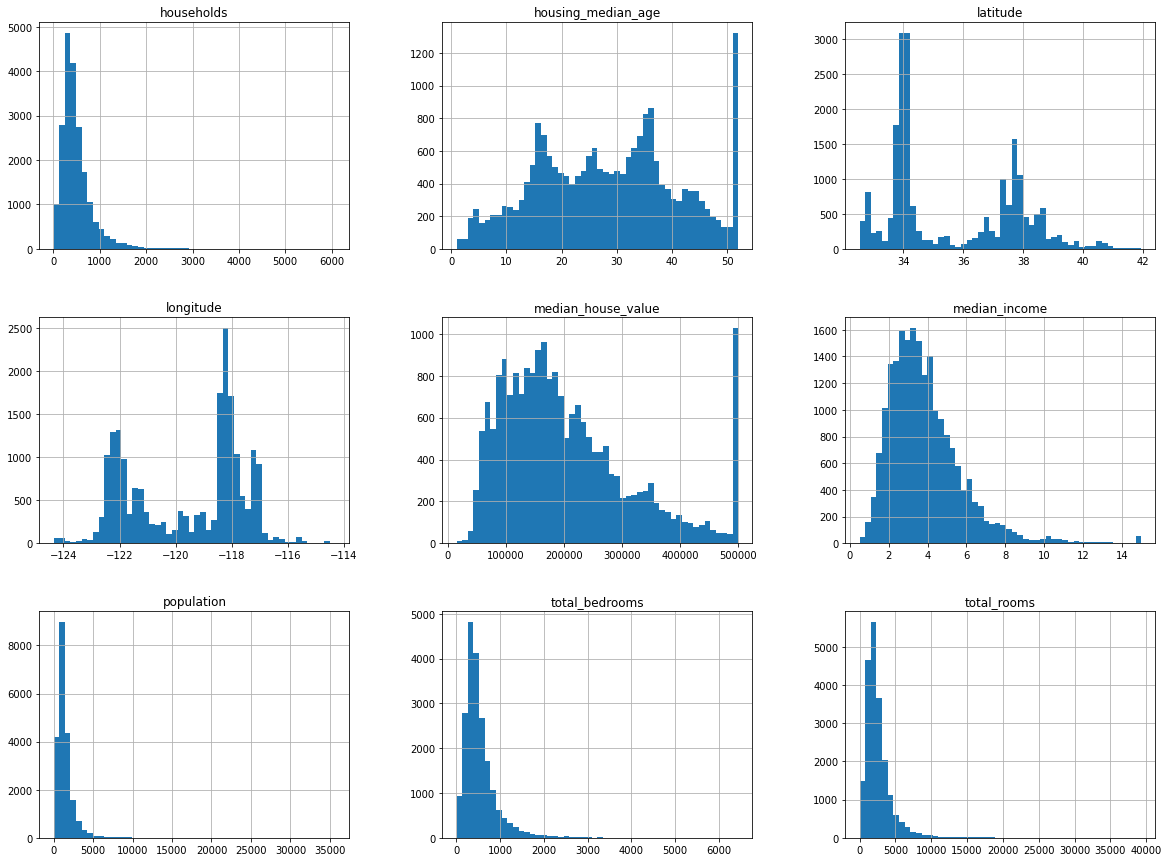

In [6]:
housing.hist(bins=50,figsize=(20,15));

## Split Test Set

Median income is deemed an important feature. Hence, the train,test split is stratified in a way that we have an equal proportion of data in each set from each category of median income.
Note that median income is a continuous and not a categorical feature. A new categorical feature is added for a stratified split. After the split, each strata (catgegory) will have an equal proportion of instances in each split

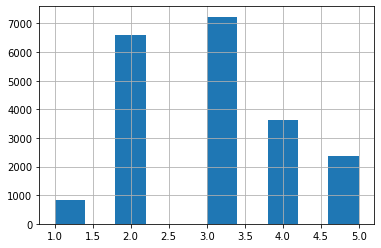

In [7]:
####### Random split
### train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)

housing['income_cat'] = pd.cut(housing["median_income"],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])
housing["income_cat"].hist()

### Stratified Shuffle Split

In [8]:
####### Stratified split
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat",axis=1,inplace=True)

housing = strat_train_set.copy()

## Explore Data

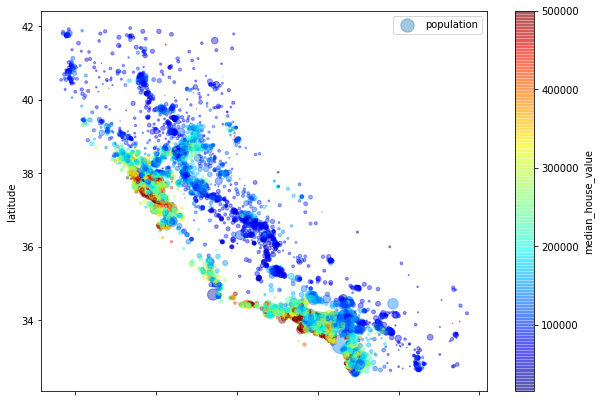

In [9]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=housing["population"]/100,label="population",c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,figsize=(10,7))
plt.legend()

### Correlations

This section computes the linear correlation coefficients ([Pearson's coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)).between each numerical variable. The correlation of the target variable with each of the features is printed.

In [10]:
corr_matrix = housing.corr()
print(corr_matrix)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

                    longitude  latitude  ...  median_income  median_house_value
longitude            1.000000 -0.924478  ...      -0.019583           -0.047432
latitude            -0.924478  1.000000  ...      -0.075205           -0.142724
housing_median_age  -0.105848  0.005766  ...      -0.111360            0.114110
total_rooms          0.048871 -0.039184  ...       0.200087            0.135097
total_bedrooms       0.076598 -0.072419  ...      -0.009740            0.047689
population           0.108030 -0.115222  ...       0.002380           -0.026920
households           0.063070 -0.077647  ...       0.010781            0.064506
median_income       -0.019583 -0.075205  ...       1.000000            0.687160
median_house_value  -0.047432 -0.142724  ...       0.687160            1.000000

[9 rows x 9 columns]
median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0

### Scatter Plot

The scatter matrix shows a scatter plot of the values of each pair of variables (target or feature). In this dataset, there are 11 variables and the scatter matrix will have 11x11 plots. For conciseness, we only plot the features that have a good correlation with the target_variable.

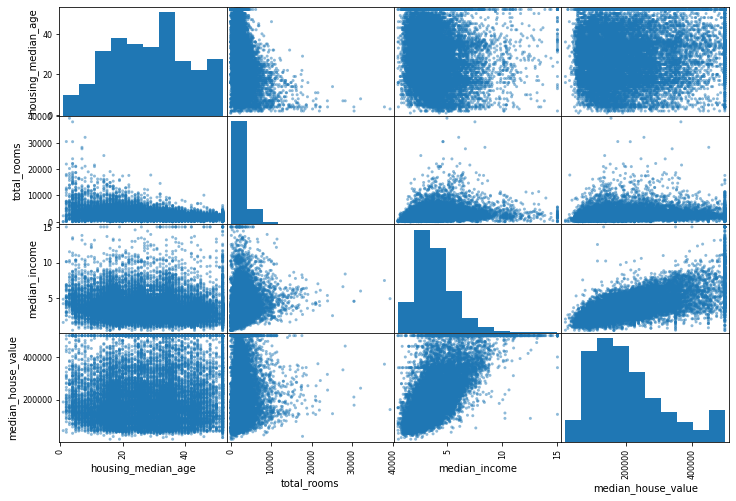

In [11]:
attributes = [k for k in corr_matrix["median_house_value"].keys() if corr_matrix["median_house_value"][k] > 0.1]
scatter_matrix(housing[attributes],figsize=(12,8));

### Attribute Combinations

In the dataset, the total_rooms, total_rooms and population are aggregate features of an entire district. This is likely to be less useful in computing the median house value. We compute per household/room averages of the rooms, bedrooms and population as follows. This clearly shows that the rooms per household has a better correlation than total rooms. The same is the case for bedrooms per room (compared to total bedrooms).

In [13]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


## Delete Data from Google Drive and Unmount

In [12]:
shutil.rmtree(download_dir)
drive.flush_and_unmount()